## Installing Resources

In [42]:
!pip install -q tensorflow
!pip install -q music21
!pip install -q scikit-learn
!pip install -q numpy
!pip install -q keras
!pip install -q matplotlib
!pip install -q pandas

import os
import glob
import numpy as np
import pandas as pd
from music21 import converter, instrument, note, chord, stream
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model 

## Data collection and Pre-Processing

In [8]:
data_dir = 'data'
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

def get_midi_files_and_labels(data_dir, composers):
    all_files = []
    all_labels = []
    for composer in composers:
        composer_path = os.path.join(data_dir, composer)
        if not os.path.exists(composer_path):
            print(f"Directory for {composer} not found. Please check your dataset path.")
            continue
        
        midi_files = glob.glob(os.path.join(composer_path, '*.mid'))
        midi_files.extend(glob.glob(os.path.join(composer_path, '*.midi')))
        
        all_files.extend(midi_files)
        all_labels.extend([composer] * len(midi_files))
        
    return all_files, all_labels

midi_files, labels = get_midi_files_and_labels(data_dir, composers)
print(f"Found {len(midi_files)} MIDI files from {len(composers)} composers.")

def extract_notes_from_midi(file_path):
    notes = []
    try:
        midi = converter.parse(file_path)
        notes_to_parse = None
        
        # Try to partition by instrument; if that fails, just get all flat notes.
        try:
            parts = instrument.partitionByInstrument(midi)
            if parts:
                notes_to_parse = parts.getLargestGroup().flat.notes
            else:
                notes_to_parse = midi.flat.notes
        except Exception:
            notes_to_parse = midi.flat.notes
            
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalForm))
    except Exception as e:
        print(f"Error parsing file {file_path}: {e}")
        return None
    return notes

# Extract notes from all MIDI files
all_notes = []
all_file_labels = []

for file_path, label in zip(midi_files, labels):
    parsed_notes = extract_notes_from_midi(file_path)
    if parsed_notes:
        all_notes.append(parsed_notes)
        all_file_labels.append(label)

print(f"Successfully extracted notes from {len(all_notes)} files.")

# Data augmentation (optional but recommended for more robust models)
# This simple augmentation transposes the musical scores.
# You can add more complex techniques if needed.
augmented_notes = []
augmented_labels = []
for notes_list, label in zip(all_notes, all_file_labels):
    augmented_notes.append(notes_list)
    augmented_labels.append(label)
    
    # Transpose by +2 semitones
    augmented_notes.append([str(note.Note(n).transpose(2).pitch) for n in notes_list])
    augmented_labels.append(label)

all_notes = augmented_notes
all_file_labels = augmented_labels
print(f"After augmentation, we have {len(all_notes)} note sequences.")

Found 481 MIDI files from 4 composers.
Error parsing file data/Bach/Bwv0997 Partita for Lute 1mov.mid: 'Chord' object has no attribute 'normalForm'
Error parsing file data/Bach/Bwv0535 Prelude and Fugue.mid: 'Chord' object has no attribute 'normalForm'
Error parsing file data/Bach/Bwv0806 English Suite n1 05mov.mid: 'Chord' object has no attribute 'normalForm'
Error parsing file data/Bach/Bwv0998 Prelude Fugue Allegro for Lute 3mov.mid: 'Chord' object has no attribute 'normalForm'
Error parsing file data/Bach/Jesu Joy of Man Desiring.mid: 'Chord' object has no attribute 'normalForm'
Error parsing file data/Bach/Prelude and Fugue in C Sharp BWV 872.mid: 'Chord' object has no attribute 'normalForm'
Error parsing file data/Bach/Bwv0582 Passacaglia and Fugue.mid: 'Chord' object has no attribute 'normalForm'
Error parsing file data/Bach/Bwv0527 Sonate en trio n3.mid: 'Chord' object has no attribute 'normalForm'
Error parsing file data/Bach/Bwv0806 English Suite n1 03mov .mid: 'Chord' object

## Feature Extraction

In [19]:
# Flatten the list of lists and create a vocabulary of unique notes/chords
notes_flat = [item for sublist in all_notes for item in sublist]
unique_notes = sorted(list(set(notes_flat)))
note_to_int = {note: i for i, note in enumerate(unique_notes)}
vocab_size = len(unique_notes)
print(f"Total unique notes/chords (vocabulary size): {vocab_size}")

# One-hot encode the composer labels for each file
label_encoder = LabelEncoder()
encoded_file_labels = label_encoder.fit_transform(all_file_labels)

# Prepare sequences for the model
sequence_length = 100
X = []
y_composer_new = []

# Iterate through each musical piece and its corresponding label
for notes_list, encoded_label in zip(all_notes, encoded_file_labels):
    # This loop creates multiple sequences from each piece
    for i in range(0, len(notes_list) - sequence_length, 1):
        # Create a sliding window sequence of notes (X)
        sequence_in = notes_list[i:i + sequence_length]
        
        # The label for this sequence is the composer of the original piece
        X.append([note_to_int[note] for note in sequence_in])
        y_composer_new.append(encoded_label)

# One-hot encode the new composer labels
y_composer = to_categorical(y_composer_new)

# Reshape input data for CNN-LSTM
n_patterns = len(X)
X = np.reshape(X, (n_patterns, sequence_length, 1))

# Normalize the input data
X = X / float(vocab_size)
print(f"Shape of input data X: {X.shape}")
print(f"Shape of composer labels y: {y_composer.shape}")

Total unique notes/chords (vocabulary size): 61
Shape of input data X: (15972, 100, 1)
Shape of composer labels y: (15972, 4)


## Model Building

In [22]:


print(f"Training set size: {len(X_train)} samples")
print(f"Validation set size: {len(X_val)} samples")
print(f"Test set size: {len(X_test)} samples")

def build_model(input_shape, vocab_size, num_composers):
    model_input = Input(shape=input_shape)

    # CNN part: Feature extraction
    x = Conv1D(256, kernel_size=5, activation='relu', padding='causal')(model_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(128, kernel_size=5, activation='relu', padding='causal')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    # LSTM part: Sequential processing
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(128))(x)
    x = Dropout(0.2)(x)
    
    # Dense output layer for classification
    composer_output = Dense(num_composers, activation='softmax', name='composer_output')(x)
    
    model = Model(inputs=model_input, outputs=composer_output)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

model = build_model((sequence_length, 1), vocab_size, len(composers))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 100, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 50, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 25, 512)        │       788,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ composer_output (Dense)         │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,611,396 (6.15 MB)

 Trainable params: 1,611,396 (6.15 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training and Evaluation

Epoch 1/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9956 - loss: 0.0196
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to composer_prediction_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 28s 162ms/step - accuracy: 0.9956 - loss: 0.0195 - val_accuracy: 1.0000 - val_loss: 7.8547e-05
Epoch 2/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9630 - loss: 0.1404
Epoch 2: val_accuracy did not improve from 1.00000
175/175 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 0.9630 - loss: 0.1402 - val_accuracy: 1.0000 - val_loss: 3.6164e-04
Epoch 3/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9900 - loss: 0.0391
Epoch 3: val_accuracy did not improve from 1.00000
175/175 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.9900 - loss: 0.0391 - val_accuracy: 1.0000 - val_loss: 3.4349e-04
Epoch 4/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9980 - loss: 0.0056
Epoch 4: val_accuracy did not improve from 1.00000
175/175 ━━━━━━━━━━━━━━━━━━━━ 29s 163ms/step - accuracy: 0.9981 - loss: 0.0056 - val_accuracy: 1.0000 - val_loss: 1.6311e-04
Epoch 5/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 2.

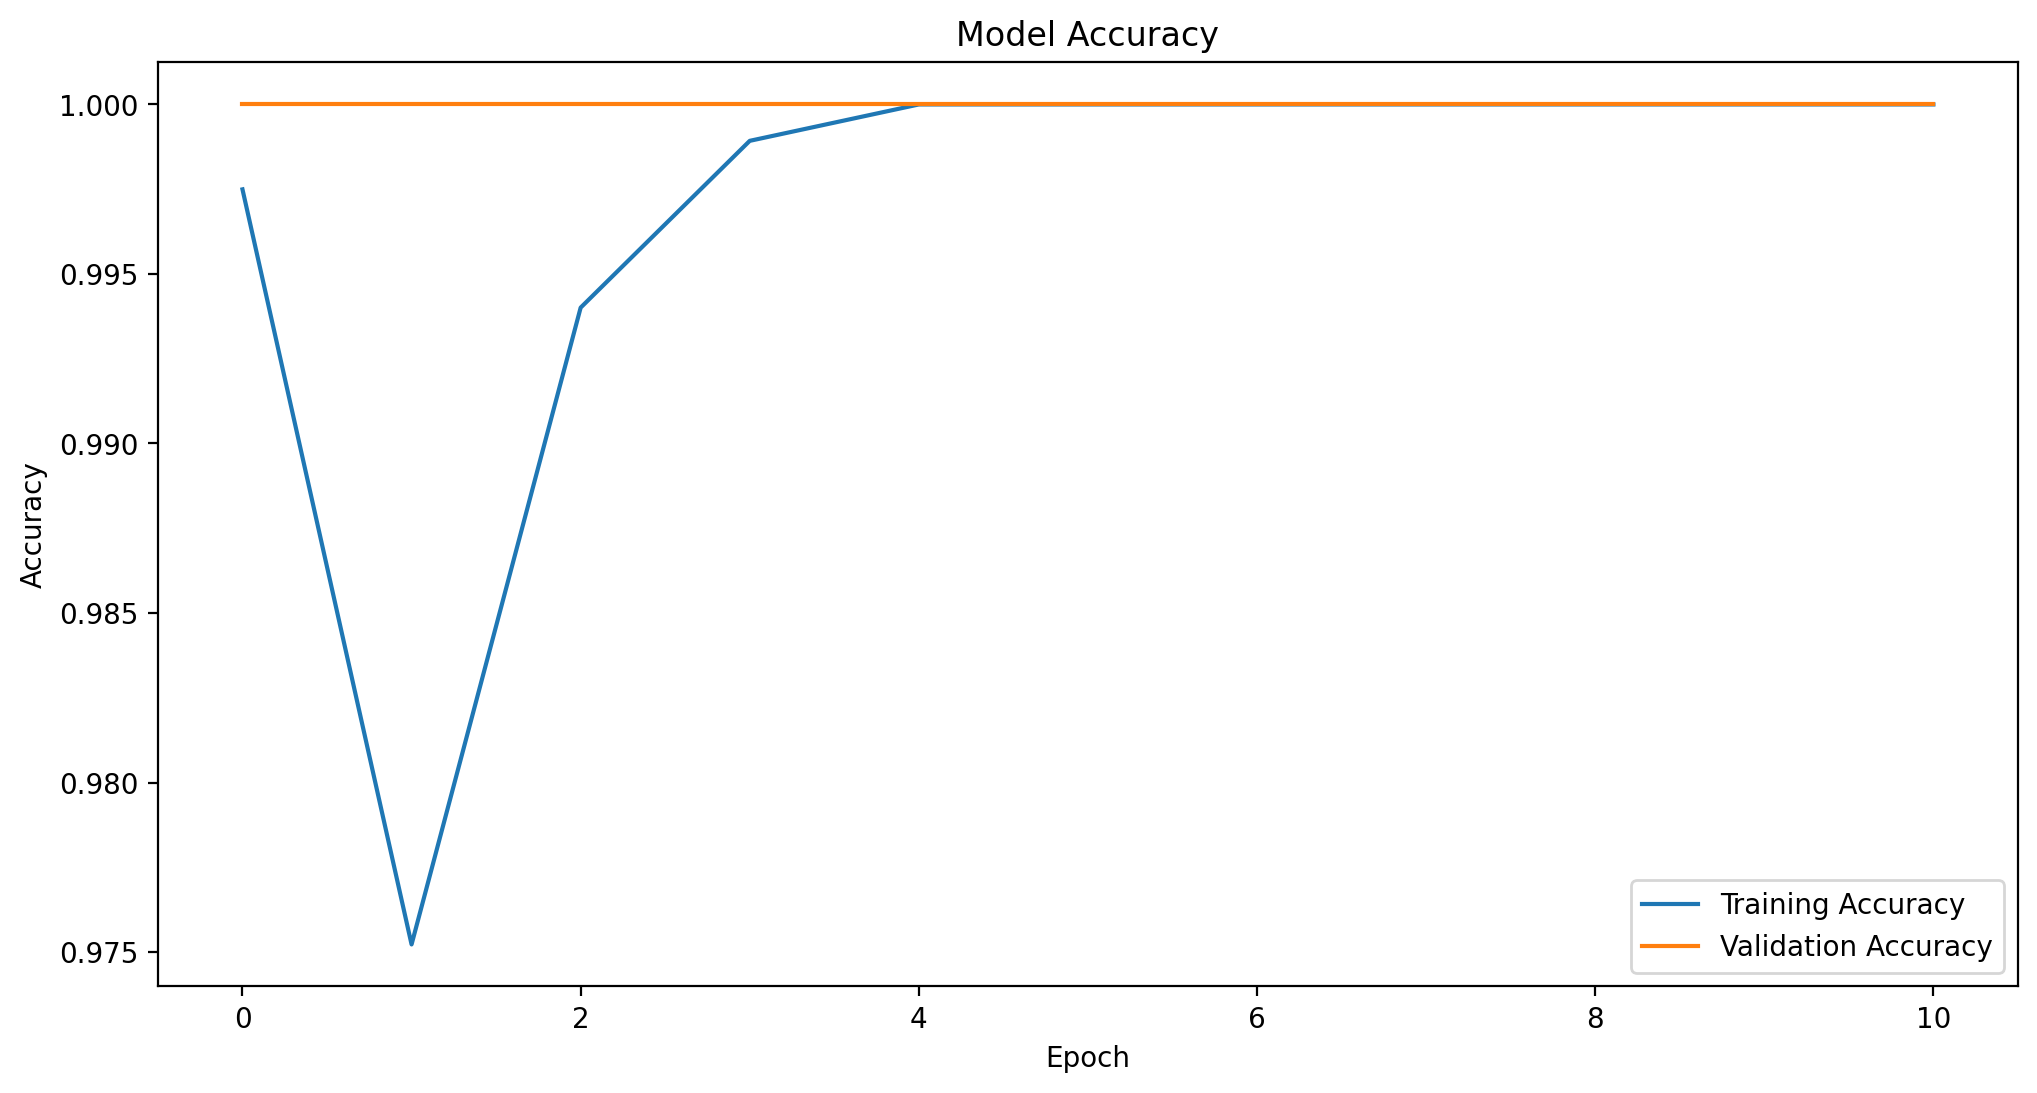


--- Validation Set Performance ---
Validation Loss: 0.0001
Validation Accuracy: 1.0000
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

Validation Set Classification Report:
              precision    recall  f1-score   support

        Bach       1.00      1.00      1.00      2085
   Beethoven       1.00      1.00      1.00        70
      Chopin       1.00      1.00      1.00        98
      Mozart       1.00      1.00      1.00       143

    accuracy                           1.00      2396
   macro avg       1.00      1.00      1.00      2396
weighted avg       1.00      1.00      1.00      2396



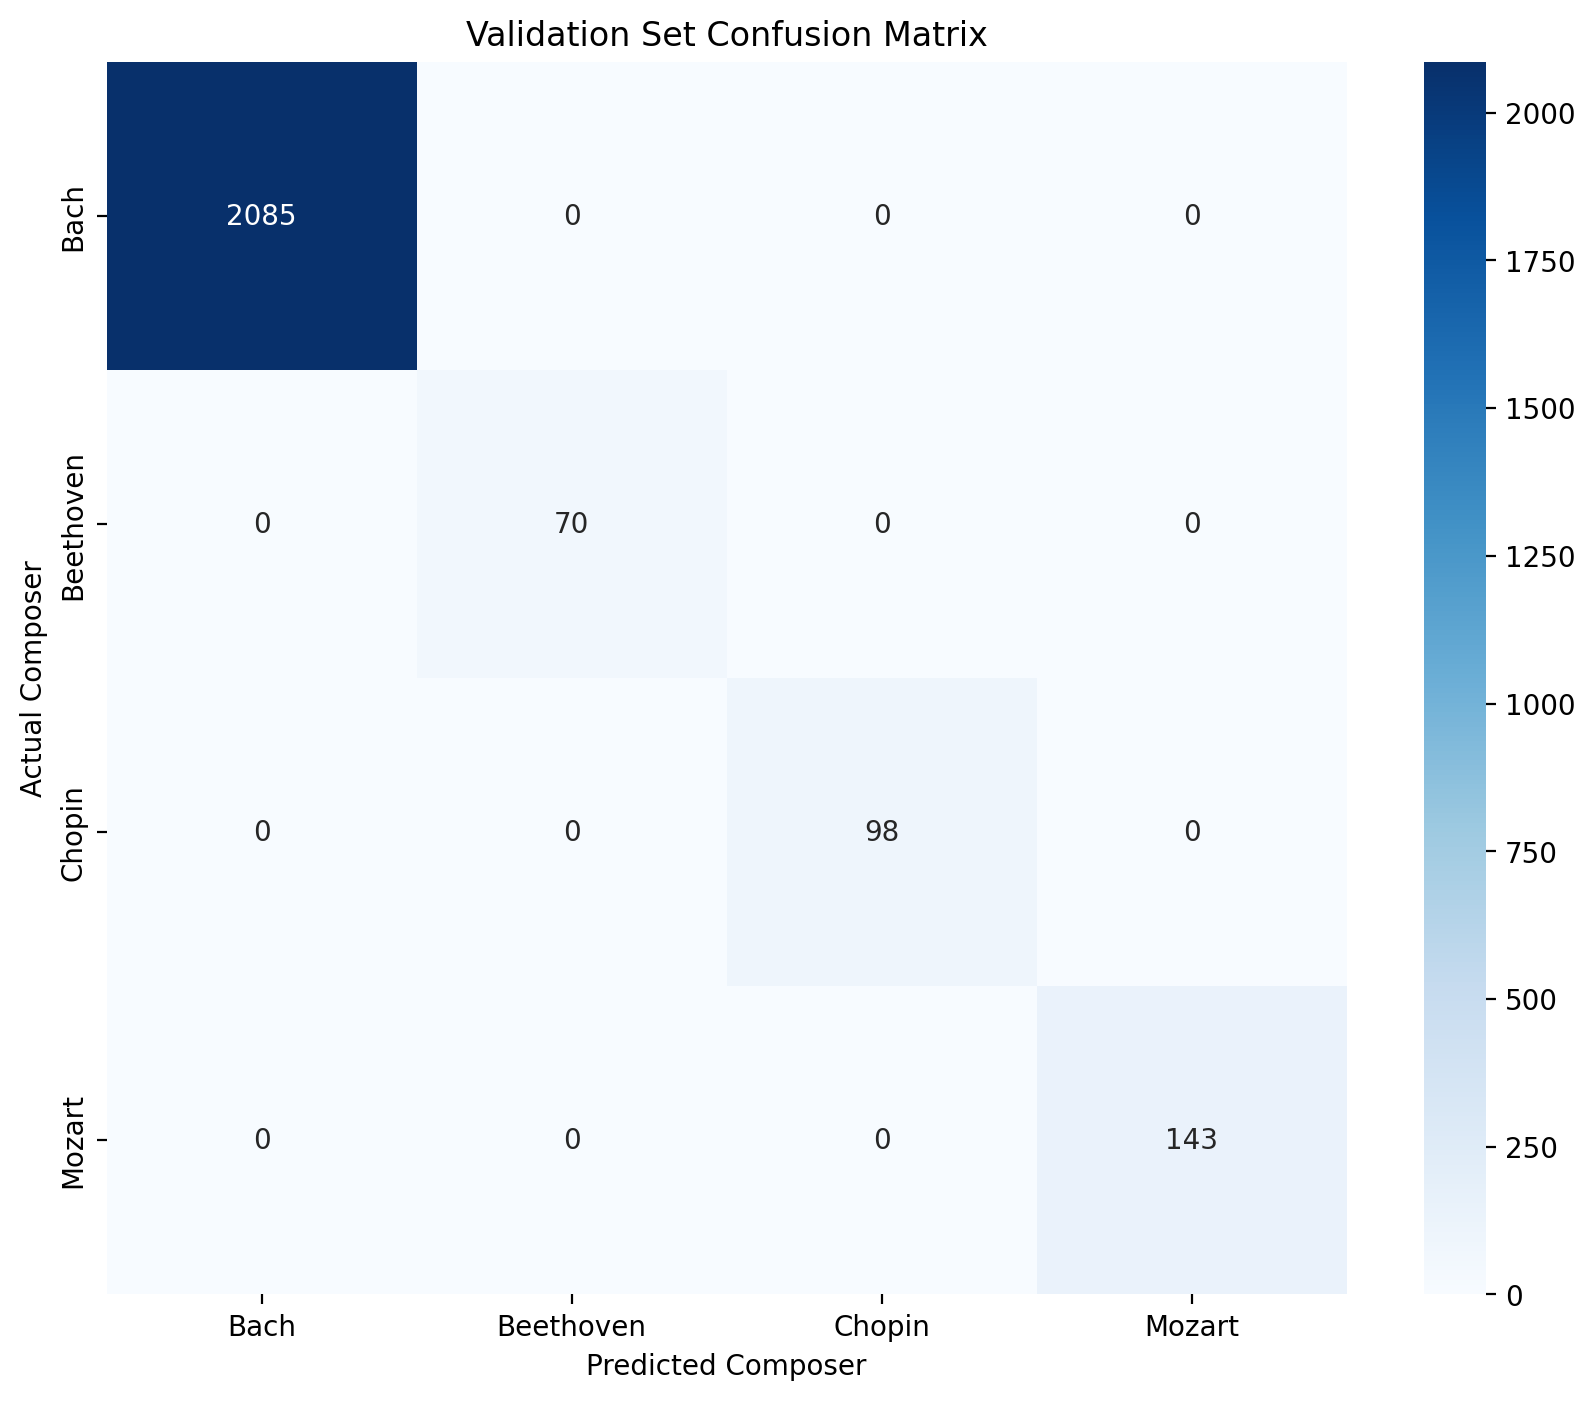


--- Final Test Set Performance ---
Final Test Loss: 0.0001
Final Test Accuracy: 1.0000
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step

Final Test Set Classification Report:
              precision    recall  f1-score   support

        Bach       1.00      1.00      1.00      2073
   Beethoven       1.00      1.00      1.00        85
      Chopin       1.00      1.00      1.00        99
      Mozart       1.00      1.00      1.00       139

    accuracy                           1.00      2396
   macro avg       1.00      1.00      1.00      2396
weighted avg       1.00      1.00      1.00      2396



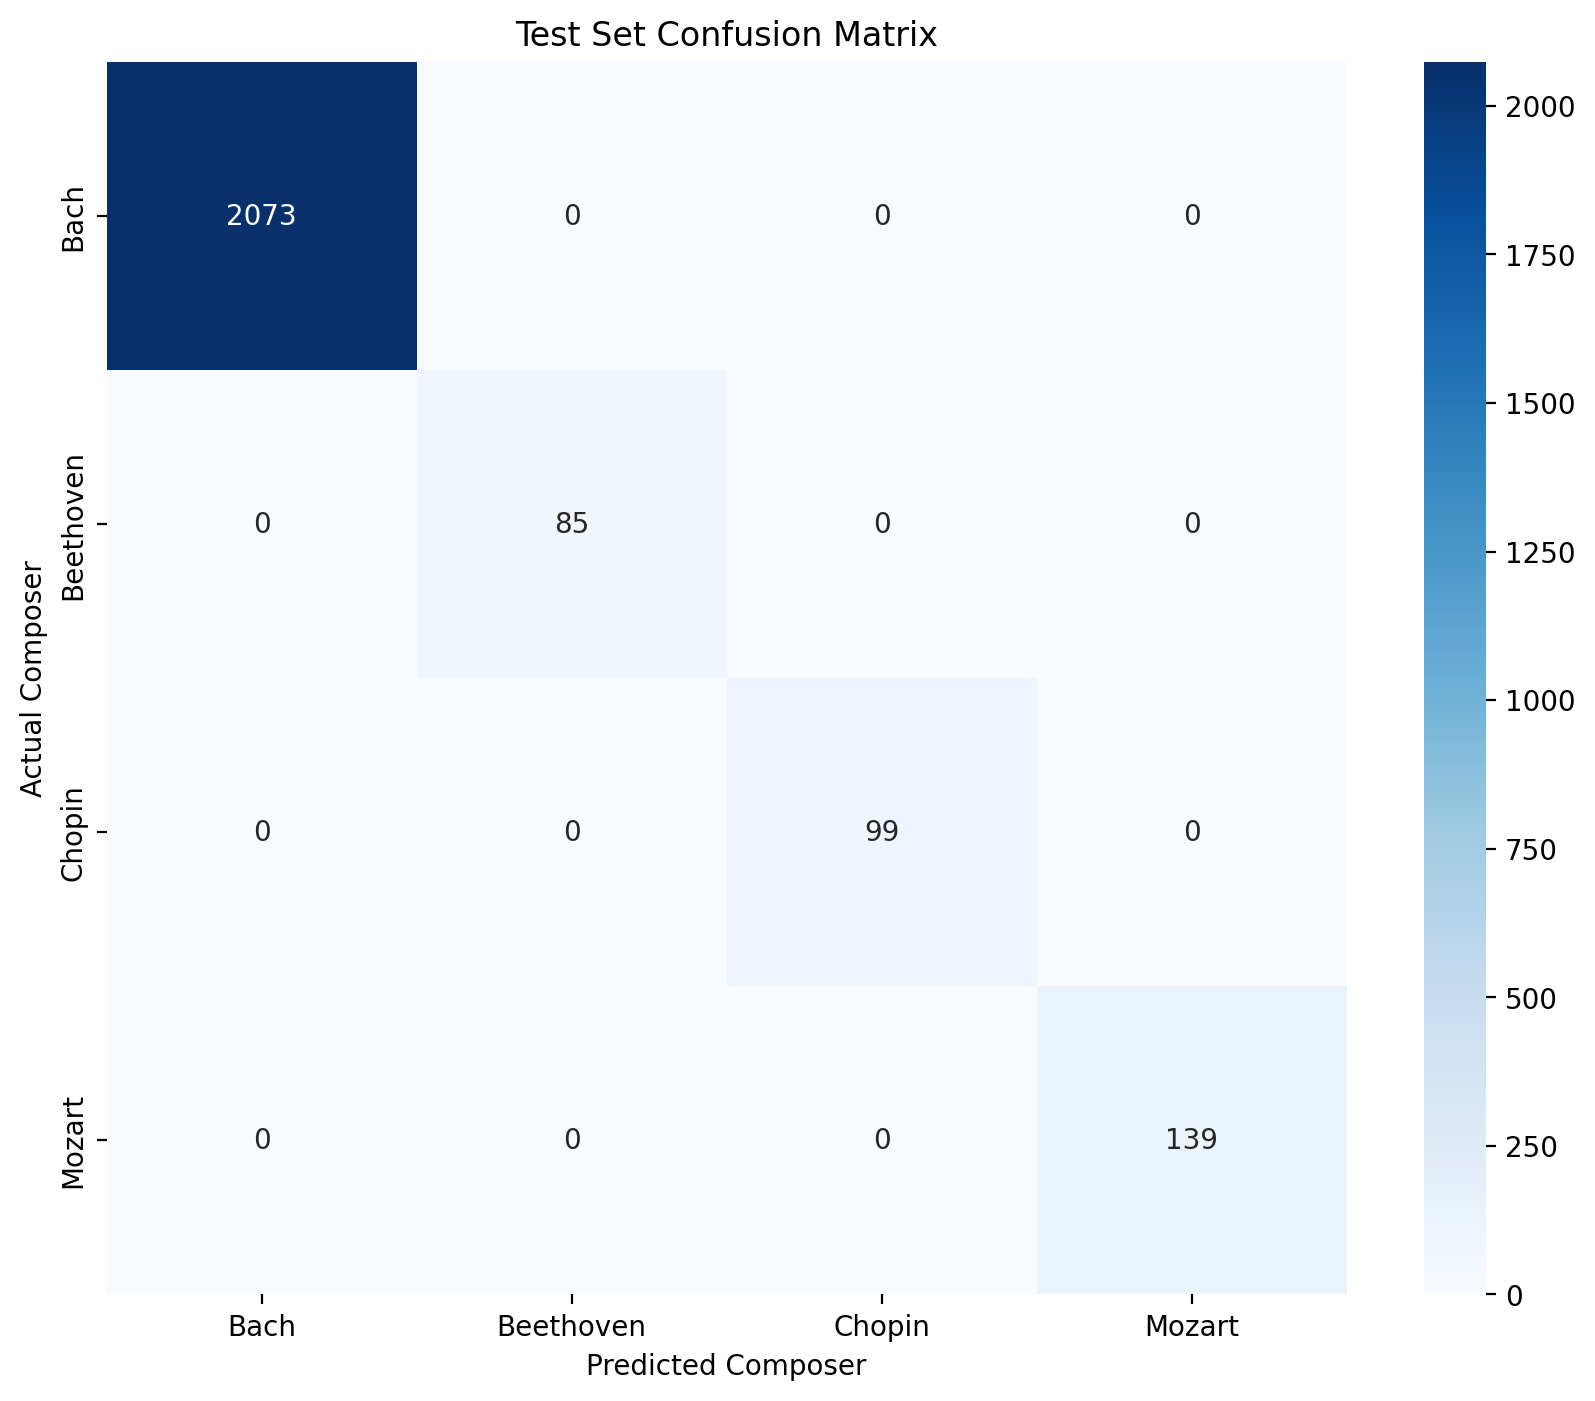

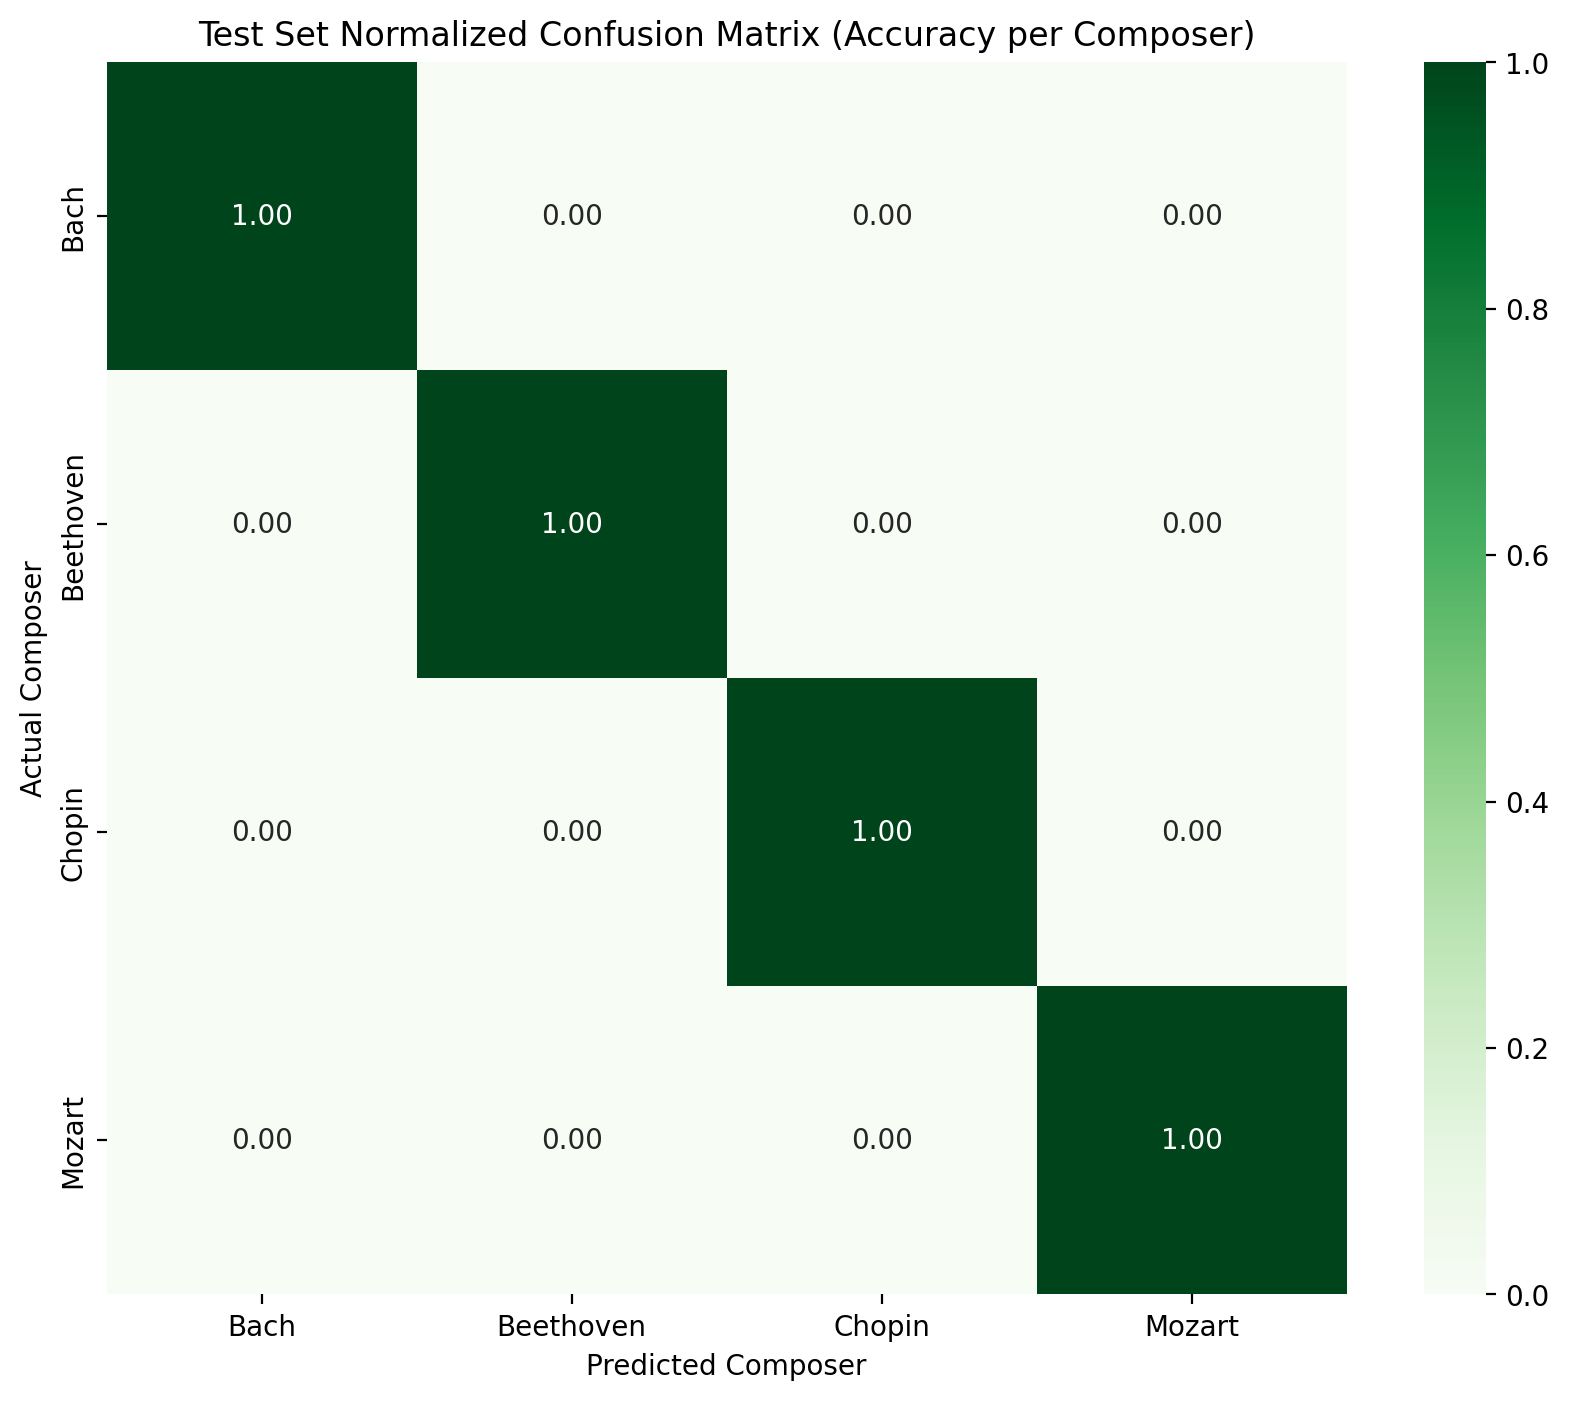

In [44]:
# Splitting data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_composer, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Model Callbacks
filepath = "composer_prediction_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1, restore_best_weights=True)
callbacks_list = [checkpoint, early_stopping]

# Training the model
history = model.fit(X_train, y_train, 
                    epochs=200, 
                    batch_size=64, 
                    validation_data=(X_val, y_val), 
                    callbacks=callbacks_list, 
                    verbose=1)

# Plotting the training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Get the best model
best_model = load_model("composer_prediction_model.h5")

# --- Validation Set Metrics ---
print("\n--- Validation Set Performance ---")
val_loss, val_accuracy = best_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Get predictions for validation set
y_val_pred_probs = best_model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
composer_names = label_encoder.classes_

# Print Classification Report for validation set
print("\nValidation Set Classification Report:")
print(classification_report(y_val_labels, y_val_pred, target_names=composer_names))

# Plot Confusion Matrix for validation set
cm_val = confusion_matrix(y_val_labels, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=composer_names, yticklabels=composer_names)
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Predicted Composer')
plt.ylabel('Actual Composer')
plt.show()

# --- Test Set Metrics (Final, Unbiased Evaluation) ---
print("\n--- Final Test Set Performance ---")
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Get predictions for test set
y_test_pred_probs = best_model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Print Classification Report for test set
print("\nFinal Test Set Classification Report:")
print(classification_report(y_test_labels, y_test_pred, target_names=composer_names))

# Plot Confusion Matrix for test set
cm_test = confusion_matrix(y_test_labels, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=composer_names, yticklabels=composer_names)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Composer')
plt.ylabel('Actual Composer')
plt.show()

# Plot Normalized Confusion Matrix for test set
cm_normalized = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', xticklabels=composer_names, yticklabels=composer_names)
plt.title('Test Set Normalized Confusion Matrix (Accuracy per Composer)')
plt.xlabel('Predicted Composer')
plt.ylabel('Actual Composer')
plt.show()

